# MODEL 1: Linear solution (MLP with Dropout)

In this exercise, we are asked to build a `Seq2Vec` model using only nn.Linear() layers. Using the values of a set of features at timepoints $t-k$ through $t-1$, we are asked to predict the following targets at timepoint $t$: 

- `p(mbar)`, atmospheric pressure
- `T (degC)`, air temperature
- `rh (%)`, relative humidity
- `wv(m/s)`, wind velocity

Because an `MLP` can only take a fixed number of values, we will first initialize the model at $k = 4$. Then, once we get that model working, we will set $k$ as a hyperparameter and iterate through `{4, 6, 8}`, along with two learning rate values`{0.001, 0.002}`and two dropout values`{0.2, 0.5}`.

## We define the first model using k = 4

In [1]:
# Let's check our current working directory 
import os
print(os.getcwd())

C:\Users\usuario\RecogniChess


In [2]:
# First we will import the necessary dependencies
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler
import pytorch_lightning as L
import torch.utils.data 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

In [3]:
# We determine whether CUDA is available 
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce GTX 960M


In [4]:
# We empty the CUDA cache for good measure and verify cache and RAM are at zero
torch.cuda.empty_cache()
print(f"CUDA cache used: {torch.cuda.memory_reserved() / 1e6:.1f} MB") 
print(f"CUDA RAM used: {torch.cuda.memory_allocated() / 1e6:.1f} MB")

CUDA cache used: 0.0 MB
CUDA RAM used: 0.0 MB


We are ready to initialize our model class. We will use a very simple architecture with only one hidden layer containing `100` units and an output layer that will output `4` predictions, one per target. The hidden layer output will go through a ReLU activation function, and the output layer will go through a sigmoid function to yield the predicted values for each of our four target variables. Dropout will be set at `0.2` for now. Note that we will define $k = 4$ right away, in the very first line, in order to establish the input features as $15$ * $k$ right off the bat:

In [5]:
# We define our model class

k = 4 # We will set k to be the number of timesteps that we will consider prior to time t
in_features = 15

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = x.view(-1, k*in_features) # reshape input tensor
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x
        
torch.manual_seed(42)
model = MLP(in_features=15*k, hidden_features=100, out_features=4, dropout_rate=0.2).to(device)

In [6]:
# Let's take a look at the model architecture
model

MLP(
  (fc1): Linear(in_features=60, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

We see that the input features to the model will be `60`. This means that we will concatenate the values of our `15` features four times (as $k = 4$), in sequential order, into a single array that will be passed to the model. This is not the best way to take into account previous timepoints, but it is one of the few viable options that an `MLP` allows for timeseries data. As a limitation to this approach, we note that this can only work for small values of $k$, as every new timestep increases the feature set by `15`, in our case.

Before we can proceed to define our Dataset subclass, which will be used to perform the following operations: 

- Use pandas to import the CSV file containing the **training** data from its local directory 
- Compute a new feature based on the timestamp column for the `hour` at which the measurements were taken
- Use MinMax scaling to normalize the data (see below)
- Within the Dataset class, divide the data columns given by the pandas df into **inputs** and **targets**
- Convert the resulting objects into `torch.tensors` that can be readily passed into DataLoaders

In [7]:
# We import the training data
df = pd.read_csv(r"C:\Users\usuario\RecogniChess\HW4\weather_train.csv", header = 0, parse_dates = [0])

In [8]:
# Let's take a look
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Data looks good, but we need to apply a couple of changes: 
- First, we need to compute a new variable called 'hour' that will indicate the time of the day. For this we will use the very first column, 'Date Time', which already contains this info. However, once we have 'hour' we don't need 'Date Time' anymore, so we will switch them.
- Second, we seriously need to minmax scale these columns because they're on vastly different scales right now.

In [9]:
# We create the hour column
df['Date Time'] = pd.to_datetime(df['Date Time'])
hour_col = pd.Series(df['Date Time'].dt.hour, name='hour')
df = pd.concat([hour_col, df.iloc[:, 1:]], axis=1)

In [10]:
# And take a look again
df.head()

,hour,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,1,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,3,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,4,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,5,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


The hour variable has been successfully created and it has taken the place of the original column. Let's proceed to minmax scaling:

In [11]:
# Now we MinMax scale every column
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [12]:
# And take a look again
df_scaled.head(7)

,hour,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.043478,0.826438,0.251840,0.246773,0.334726,0.934974,0.041136,0.084913,0.004548,0.082574,0.083781,0.743542,0.014989,0.026809,0.535278
1,0.086957,0.827634,0.237631,0.232507,0.314041,0.921040,0.037476,0.076166,0.005026,0.074032,0.075188,0.756682,0.017844,0.026809,0.528611
2,0.130435,0.829828,0.238829,0.233356,0.316339,0.924524,0.037650,0.077259,0.004787,0.075171,0.076262,0.756473,0.012848,0.026809,0.464444
3,0.173913,0.831323,0.234720,0.229110,0.308817,0.914073,0.036604,0.074344,0.005505,0.072323,0.073040,0.760753,0.007138,0.016170,0.666667
4,0.217391,0.836008,0.224790,0.218580,0.295654,0.909429,0.034339,0.069242,0.005505,0.067198,0.068027,0.771469,0.028551,0.037447,0.436111
5,0.260870,0.838501,0.224105,0.217561,0.296281,0.915235,0.034164,0.069242,0.005026,0.067198,0.068385,0.773025,0.003569,0.021277,0.405556
6,0.304348,0.844681,0.232666,0.225374,0.307146,0.917557,0.036082,0.073615,0.005266,0.071185,0.072324,0.767847,0.148465,0.122553,0.968889


Every variable is now on a scale from 0 to 1, which will make it much easier for our model to learn. We can now create a Dataset class:

In [13]:
class WeatherDataset(Dataset):
    def __init__(self, k=k):
        self.df = df_scaled

        self.input_cols = ['hour'] + list(self.df.columns[1:15])
        self.target_cols = list(self.df.columns[[1,2,5,12]])

        self.k = k

    def __len__(self):
        return len(self.df) - self.k - 1
    
    def __getitem__(self, idx):
        input_values = np.array([self.df.iloc[i][self.input_cols] for i in range(idx, idx+self.k)], dtype=np.float32)
        target_values = np.array(self.df.iloc[idx+self.k][self.target_cols], dtype=np.float32)

        # We reshape the input values to flatten the dimension containing the sequence length (k)
        input_values = input_values.reshape(-1)

        # Verify the input and target shapes
        assert input_values.shape == (self.k*len(self.input_cols),), f"Input shape mismatch: {input_values.shape}"
        assert target_values.shape == (len(self.target_cols),), f"Target shape mismatch: {target_values.shape}"

        # Convert input and targets to torch.tensors
        input_tensor = torch.tensor(input_values, dtype=torch.float32)
        target_tensor = torch.tensor(target_values, dtype=torch.float32)

        return input_tensor, target_tensor


In [14]:
# We are ready to define our training and test datasets
train_dataset = WeatherDataset(k=k)
#test_dataset = WeatherDataset(root_dir=r"C:\Users\usuario\RecogniChess\HW4", train_or_test='weather_test.csv', k=k)

In [15]:
# We will now print the length of each dataset to verify the __len__() function works
print("The training dataset contains:", len(train_dataset), "rows")
#print("The test dataset contains", len(test_dataset), "rows")

The training dataset contains: 56067 rows


The length value we obtain is equal to the original length of the dataset $-$ $k$ $-$ $1$

In [16]:
# We will now print the first example in the training dataset to verify the __getitem__() function works
print("Training dataset example (normalized):" , train_dataset[0])

Training dataset example (normalized): (tensor([0.0435, 0.8264, 0.2518, 0.2468, 0.3347, 0.9350, 0.0411, 0.0849, 0.0045,
        0.0826, 0.0838, 0.7435, 0.0150, 0.0268, 0.5353, 0.0870, 0.8276, 0.2376,
        0.2325, 0.3140, 0.9210, 0.0375, 0.0762, 0.0050, 0.0740, 0.0752, 0.7567,
        0.0178, 0.0268, 0.5286, 0.1304, 0.8298, 0.2388, 0.2334, 0.3163, 0.9245,
        0.0377, 0.0773, 0.0048, 0.0752, 0.0763, 0.7565, 0.0128, 0.0268, 0.4644,
        0.1739, 0.8313, 0.2347, 0.2291, 0.3088, 0.9141, 0.0366, 0.0743, 0.0055,
        0.0723, 0.0730, 0.7608, 0.0071, 0.0162, 0.6667]), tensor([0.8360, 0.2248, 0.9094, 0.0286]))


Although they are normalized, we see that our model has concatenated the values of our 15 features at:

- Timestep t-4 : 0.0435, 0.8264, 0.2518, 0.2468, 0.3347, 0.9350, 0.0411, 0.0849, 0.0045, 0.0826, 0.0838, 0.7435, 0.0150, 0.0268, 0.5353 
- Timestep t-3 : 0.0870, 0.8276, 0.2376,  0.2325, 0.3140, 0.9210, 0.0375, 0.0762, 0.0050, 0.0740, 0.0752, 0.7567, 0.0178, 0.0268, 0.5286 
- Timestep t-2 : 0.1304, 0.8298, 0.2388, 0.2334, 0.3163, 0.9245,  0.0377, 0.0773, 0.0048, 0.0752, 0.0763, 0.7565, 0.0128, 0.0268, 0.4644
- Timestep t-1 : 0.1739, 0.8313, 0.2347, 0.2291, 0.3088, 0.9141, 0.0366, 0.0743, 0.0055,  0.0723, 0.0730, 0.7608, 0.0071, 0.0162, 0.6667

In order to predict the 4 targets at: 

- Timestep t :     0.8360, 0.2248, 0.9094, 0.0286

In [17]:
# Let's make sure we can subset this example to get its target value (label), which corresponds to the Temperature, DewPoint, RelativeHumidity and WindSpeed values at timepoint t
print("Target values of training dataset example 1 (normalized):" , train_dataset[0][1])

Target values of training dataset example 1 (normalized): tensor([0.8360, 0.2248, 0.9094, 0.0286])


In [18]:
# We are finally ready to define the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

Before proceeding, one final litmus test is in order. Namely, we need to verify that our matrix sizes are compatible with each other. If our model has been defined correctly, we should have: 

- Model inputs: consisting of batch size `32` in dimension $1$ and the $k$-long concatenated feature values in dimension $2$ (`60`)
- Model targets: consisting of batch size `32`in dimension $1$ and the `4`model targets (labels)
- Model outputs: consisting of batch size `32`in dimension $1$ and the `4`predicted values

Where the shape of outputs and targets must be the same in order to effectively compute a Loss at each model pass:

In [19]:
# Let's get a batch of inputs and targets to verify we have the right matrix shapes

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

# Pass the inputs through the model
outputs = model(inputs)
outputs = outputs.to(device)

# Print the shapes of the tensors
print(f"Inputs shape: {inputs.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Outputs shape: {outputs.shape}")

Inputs shape: torch.Size([32, 60])
Targets shape: torch.Size([32, 4])
Outputs shape: torch.Size([32, 4])


We get exactly what we expected. The first dimension is the batch size, `32`, which is common to all three tensors. Then, our model then takes `15` features at 4 different timpoints ($t-k$ ... $t-1$) and concatenates them ($11$ x $k$) to create an input shape of `60` features. These are used to predict `4` targets (y_preds) at timepoint `t` and compare them to the true labels (y_trues) at timepoint `t`. We have verified that the shape of our model targets and outputs is the same, and so we are ready to proceed to model training:

## First model pass

In [87]:
# We begin by splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # We will set the batch size to 64 to speed things up
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) # We will set the batch size to 64 to speed things up

In [88]:
# We define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002) # We will also set the learning rate relatively high 

# We define the number of epochs to train for
num_epochs = 10
# We define the number of iterations to print loss at
print_every = 500
# We initialize the iteration counter
iteration = 0

# We initialize lists to store training and validation losses and R2s for each epoch
train_losses = []
val_losses = []
train_r2s = []
val_r2s = []

In [89]:
##############
# TRAINING LOOP #
#############

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_train_r2 = 0.0
    epoch_val_loss = 0.0
    epoch_val_r2 = 0.0
    model.train()
    for inputs, targets in train_loader:
        # Move the inputs and targets to the device (GPU or CPU)
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        train_loss = criterion(outputs, targets)
        train_r2 = torchmetrics.functional.r2_score(outputs, targets)
        
        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        epoch_train_r2 += train_r2.item()  
        
        # Calculate the average training loss and R2 for the epoch
        train_loss = epoch_train_loss / len(train_loader)
        train_r2 = epoch_train_r2 / len(train_loader)  
                                      
        # Print the training loss at every print_every iterations
        if iteration % print_every == 0:
            print(f"Iteration {iteration} - Training Loss: {train_loss:.4f} Training R-squared: {train_r2:.4f}")
            
        iteration += 1
       
    # Compute the average training loss and R2 for the epoch
    avg_epoch_train_loss = epoch_train_loss / len(train_loader)
    avg_epoch_train_r2 = epoch_train_r2 / len(train_loader)
    
    # Append the training loss and R2 to the lists
    train_losses.append(avg_epoch_train_loss)
    train_r2s.append(avg_epoch_train_r2)
    
    ###############
    # VALIDATION LOOP #
    ##############
    
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move the inputs and targets to the device (GPU or CPU)
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            val_r2 = torchmetrics.functional.r2_score(outputs, targets)
            
            epoch_val_loss += val_loss.item()
            epoch_val_r2 += val_r2.item()  
        
        # Compute the average validation loss and R2 for the epoch
        avg_epoch_val_loss = epoch_val_loss / len(val_loader)
        avg_epoch_val_r2 = epoch_val_r2 / len(val_loader)  
        
        # Append the validation loss and R2 to the lists
        val_losses.append(avg_epoch_val_loss)
        val_r2s.append(avg_epoch_val_r2)
    
    # Print the average loss and R2 for the epoch
    print(f"Epoch {epoch+1} - Training Loss: {avg_epoch_train_loss:.4f} Training R-squared: {avg_epoch_train_r2:.4f} Validation Loss: {avg_epoch_val_loss:.4f} Validation R-squared: {avg_epoch_val_r2:.4f}")


Iteration 0 - Training Loss: 0.0001 Training R-squared: -0.0083
Iteration 500 - Training Loss: 0.0054 Training R-squared: 0.3276
Epoch 1 - Training Loss: 0.0064 Training R-squared: 0.5326 Validation Loss: 0.0026 Validation R-squared: 0.8017
Iteration 1000 - Training Loss: 0.0014 Training R-squared: 0.3246
Epoch 2 - Training Loss: 0.0031 Training R-squared: 0.7744 Validation Loss: 0.0021 Validation R-squared: 0.8480
Iteration 1500 - Training Loss: 0.0004 Training R-squared: 0.1133
Iteration 2000 - Training Loss: 0.0024 Training R-squared: 0.6865
Epoch 3 - Training Loss: 0.0027 Training R-squared: 0.8044 Validation Loss: 0.0019 Validation R-squared: 0.8693
Iteration 2500 - Training Loss: 0.0015 Training R-squared: 0.4628
Epoch 4 - Training Loss: 0.0026 Training R-squared: 0.8167 Validation Loss: 0.0018 Validation R-squared: 0.8720
Iteration 3000 - Training Loss: 0.0007 Training R-squared: 0.2310
Iteration 3500 - Training Loss: 0.0025 Training R-squared: 0.8190
Epoch 5 - Training Loss: 0.

We stored the performance metrics at every epoch, so we can now plot the learning curves for both training and validation sets:

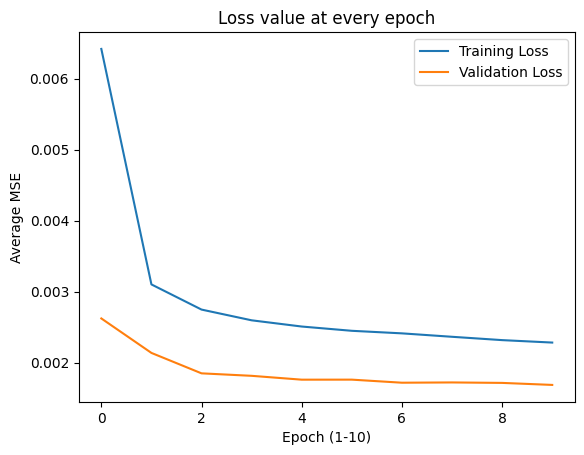

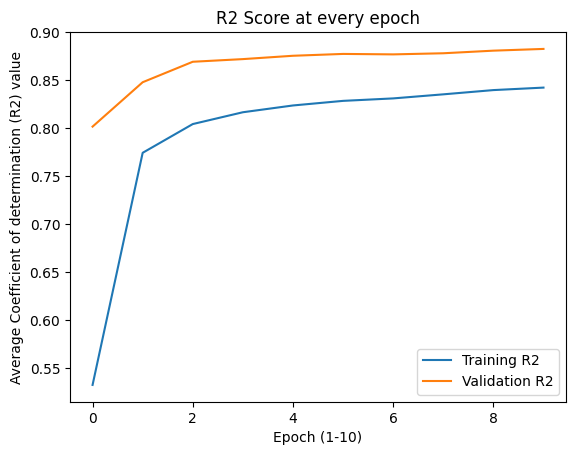

In [90]:
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss value at every epoch')
plt.xlabel('Epoch (1-10)')
plt.ylabel('Average MSE')
plt.show()

# Plot the training and validation R2 scores
plt.plot(train_r2s, label='Training R2')
plt.plot(val_r2s, label='Validation R2')
plt.legend()
plt.title('R2 Score at every epoch')
plt.xlabel('Epoch (1-10)')
plt.ylabel('Average Coefficient of determination (R2) value')
plt.show()

The model seems to be learning at every epoch and performance is quite high already, approaching R2 values in the low 90s! More importantly, it is clear that the model is **not overfitting**, as validation performance is actually a bit better than training performance. However, we still have a long way to go. Namely, we need to set $k$ as a hyperparameter and test three different lengths: `{4, 6, 8}`. That is in addition to checking two different `learning rate` values `{0.001, 0.002}` and two different `dropout` values `{0.2, 0.5}`, and of course training for longer. 